# Binary Classification with a Bank Churn Dataset

## Models: LogisticRegression, RandomForst and XGBoost

This ia a dataset from 2024 Kaggle Playground Series where the task is to predict whether a customer continues with their account or closes it (e.g., churns). <br>
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

This notebook explores the dataset, preprocesses the data and based on ROC score, compares the performance of three classifier models - Logistic Regression, Random Forest and XGBoost.  

In [1]:
# Basic libraries for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Libraries for preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn import preprocessing
from copy import deepcopy

from sklearn.metrics import roc_auc_score

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore')

## Load & Review the data
The data is composed of a training and test dataset.  Prior to exploring the data, we look at the shape of the data, types of data and if there is missing data or null values. <br>

In [2]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# For the submission, we 
test_ids = test['id']

In [3]:
# Check the data for shape, data type and missing/null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


The dataset is very clean, with no missing/null values. Some categorical features are in a decimal format.  The object column 'Surname' may be dropped during analysis.

## Preliminary Exploration of the Data
We orient ourselves with the content and format of the data, and explore statistical distributions.  Using visualizations, we can identify patterns in the interaction of covariates, the presence of outliers and target distributions 

In [4]:
#  Glimpse the content and format of the data 
train.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [5]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## Structure of the Data
###  Continuous Features
Using histograms and scatterplots, we can see how continunous variables are distributed and how they interact with one another

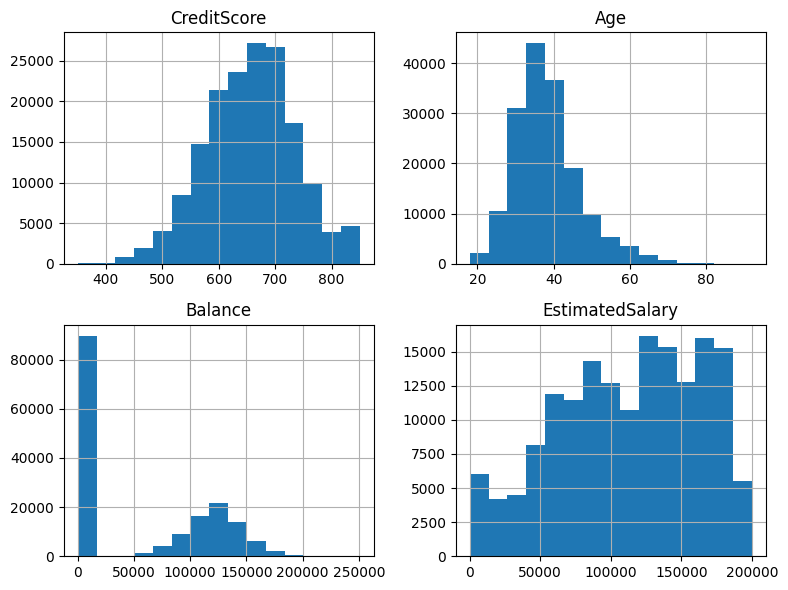

In [6]:
import matplotlib.pyplot as plt
continuous_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
train[continuous_features].hist(bins=15, figsize=(8, 6))
plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Distributions for Continuous Attributes')

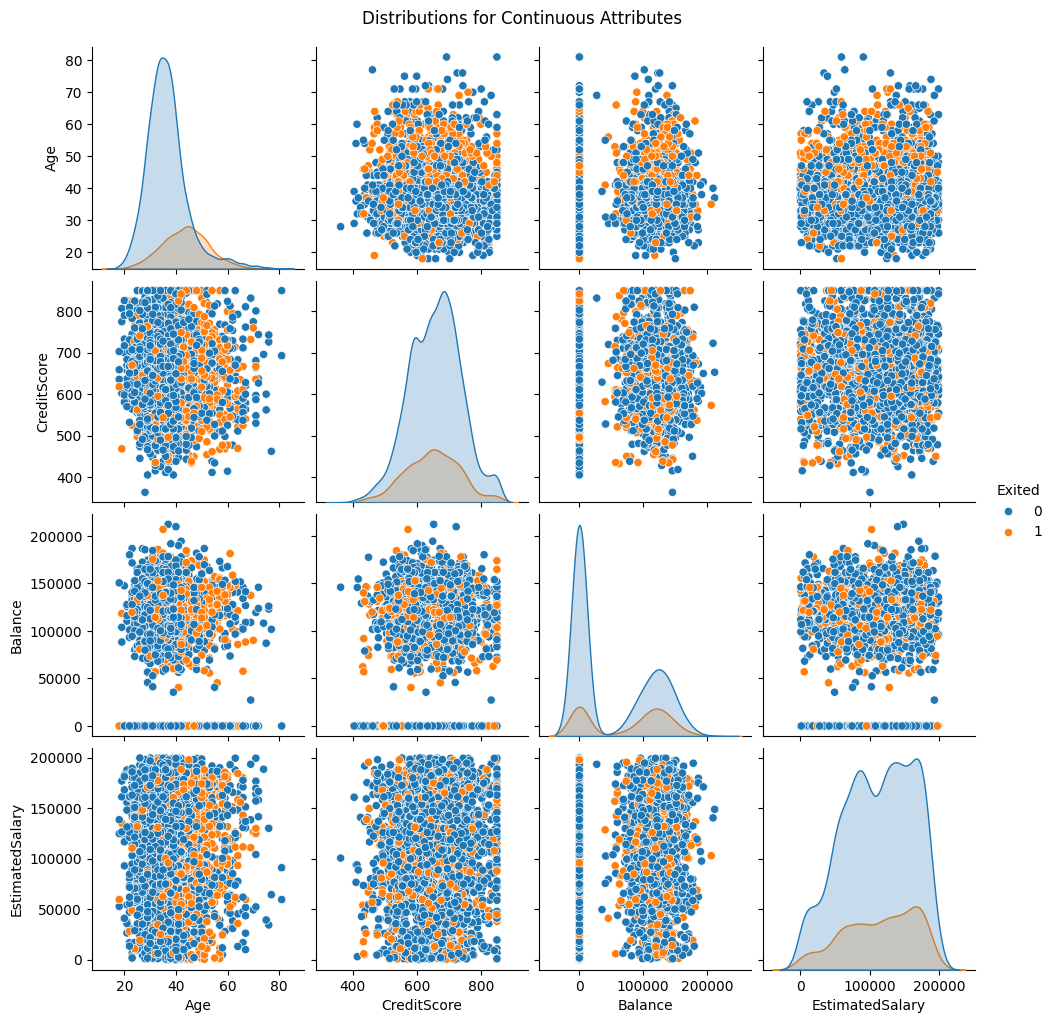

In [7]:
# The columns 'CreditScore' and 'Age' have a significant number of outliers which we should investigate
sample_data = train.sample(frac=0.025)
sns.pairplot(sample_data, vars=['Age', 'CreditScore', 'Balance', 'EstimatedSalary'], hue='Exited')
plt.suptitle("Distributions for Continuous Attributes", y=1.02)

### Interaction of Categorical Variables with Target Variable 

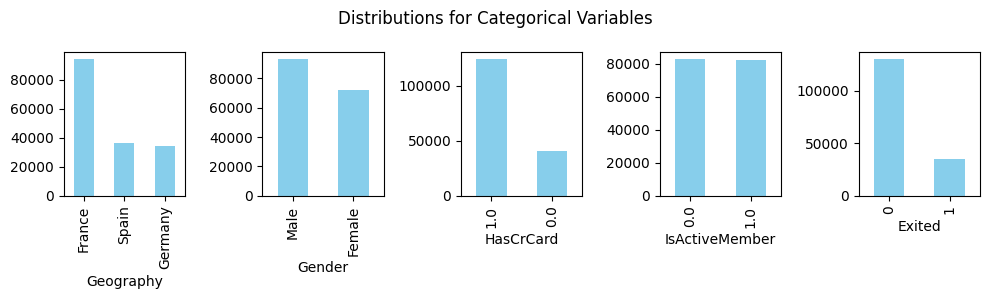

In [8]:
cat_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

fig, axes = plt.subplots(1, 5, figsize=(10, 3))

train[cat_columns[0]].value_counts().plot(kind='bar', ax=axes[0], color="skyblue")
train[cat_columns[1]].value_counts().plot(kind='bar', ax=axes[1], color="skyblue")
train[cat_columns[2]].value_counts().plot(kind='bar', ax=axes[2], color="skyblue")
train[cat_columns[3]].value_counts().plot(kind='bar', ax=axes[3], color="skyblue")
train[cat_columns[4]].value_counts().plot(kind='bar', ax=axes[4], color="skyblue")

plt.suptitle("Distributions for Categorical Variables")
plt.tight_layout()
plt.show()


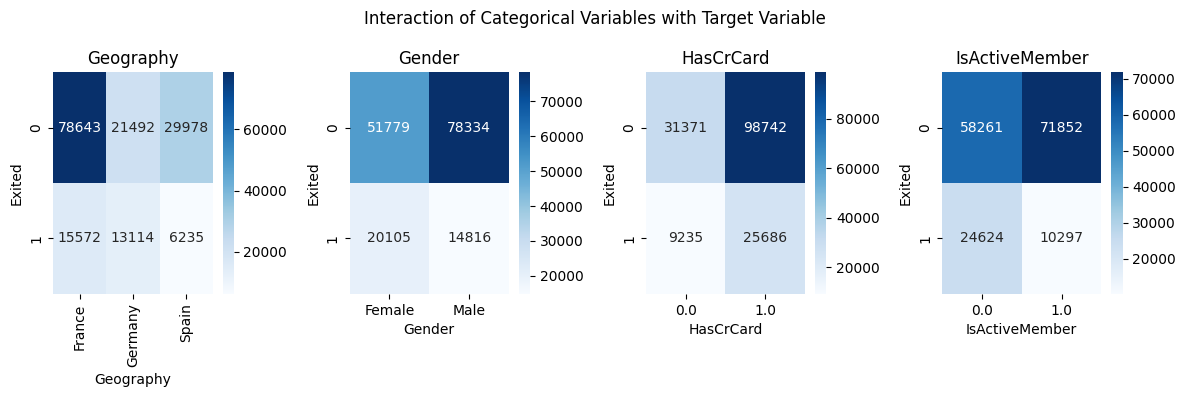

In [9]:
cat_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, col in enumerate(cat_columns):
    cross_tab = pd.crosstab(train['Exited'], train[col])
    sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Exited')
    axes[i].set_title(f'{col}')
    
plt.suptitle("Interaction of Categorical Variables with Target Variable")
plt.tight_layout()
plt.show()

The key numerical attributes are 'CreditScore', 'Age', 'Tenure', 'Balance' and 'EstimatedSalary' which we will scale during processing.
The key categorical attributes are 'Geography', 'Gender',  'HasCrCard'   'IsActiveMember', 'Exite which we will apply labels when processing
We note that there are no missing values, so no values that need to be imputed.  
We note that the outliers in the numerical variables are limited to 'Age' and 'CreditScore' d'

### Detection of Outliers
Outliers will be visualized using boxplots and any bivariate interaction between outliers can be investigated using scatter plots to detect any lineal relationships

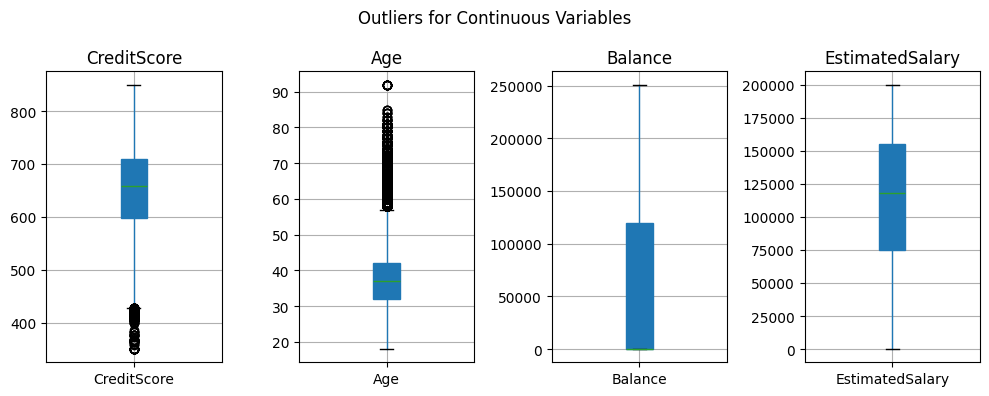

In [10]:
# Identify any outliers
continuous_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, feature in enumerate(continuous_features):
    train.boxplot(column=feature, ax=axes[i], vert=True, patch_artist=True)
    axes[i].set_title(feature)

plt.suptitle("Outliers for Continuous Variables")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Relationship between variables CreditScore & Age')

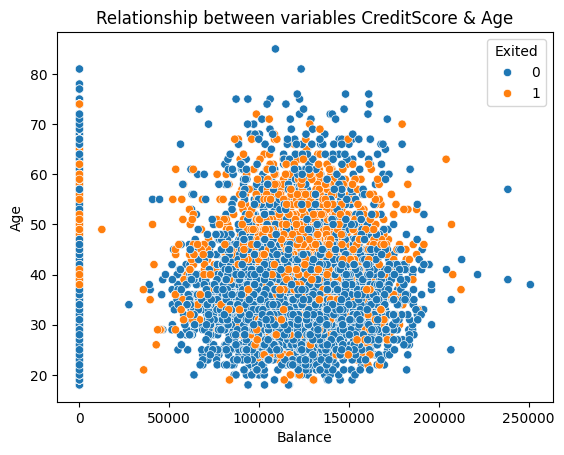

In [11]:
# The columns 'CreditScore' and 'Age' have a significant number of outliers which we should investigate
sample_data = train.sample(frac=0.1)
sns.scatterplot(x='Balance', y='Age', hue='Exited', data = sample_data)
plt.title('Relationship between variables CreditScore & Age')

# Data Preprocessing

The categorical labels are transformed to prepare the data for futher analysis and developing algorithms

In [12]:
# Drop unwanted columns
train = train.drop(['id', 'CustomerId', 'Surname'], axis = 1)
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [13]:

le = preprocessing.LabelEncoder()

for col in cat_columns:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])
    print(le.classes_)

train.head()

['France' 'Germany' 'Spain']
['Female' 'Male']
[0. 1.]
[0. 1.]


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1,0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1,1,49503.50,0
2,678,0,1,40.0,10,0.00,2,1,0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1,1,84560.88,0
4,716,2,1,33.0,5,0.00,2,1,1,15068.83,0


### Correlation Analysis

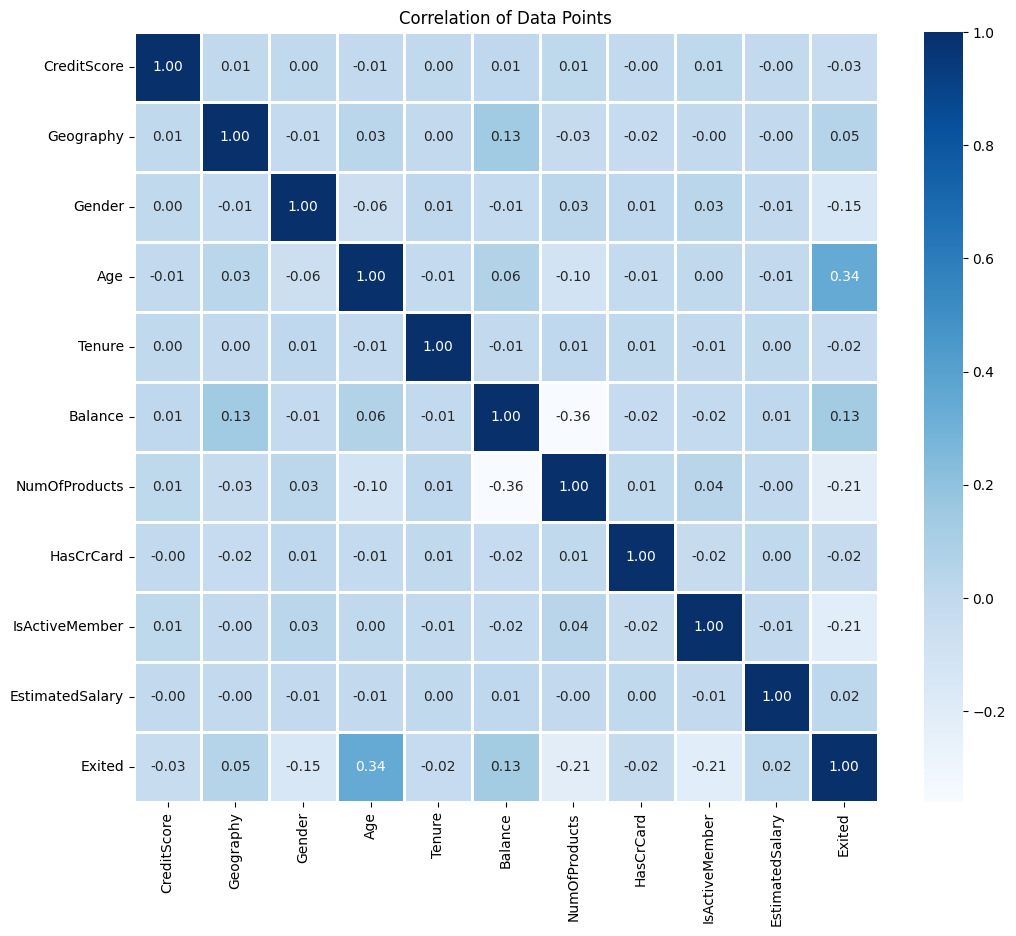

In [14]:
train_copy = train.copy()

d_corr = train_copy.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(d_corr, annot=True, fmt = ".2f", cmap='Blues', linewidths = 0.8)
plt.title("Correlation of Data Points")
plt.show()

#  Data Cleaning

## Outliers

In [15]:
Q1 = train[continuous_features].quantile(0.25)
Q3 = train[continuous_features].quantile(0.75)
IQR = Q3 - Q1

# Identify and drop rows with values outside the IQR
outlier_indices_iqr = ((train[continuous_features] < (Q1 - 1.5 * IQR)) | (train[continuous_features] > (Q3 + 1.5 * IQR))).any(axis=1)
train = train[~outlier_indices_iqr]

In [16]:
## check for NaNs - should be none
is_NaN = train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train[row_has_NaN]
print(rows_with_NaN)

Empty DataFrame
Columns: [CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


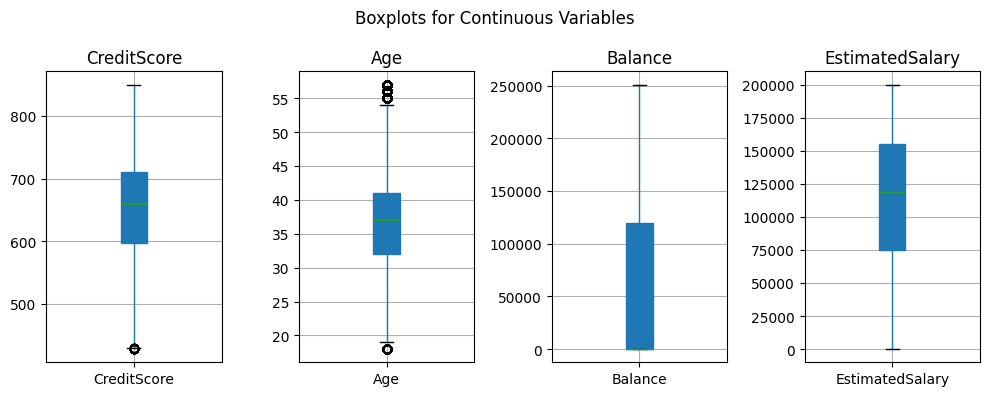

In [17]:
# Check that outliers have been removed

fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, feature in enumerate(continuous_features):
    train.boxplot(column=feature, ax=axes[i], vert=True, patch_artist=True)
    axes[i].set_title(feature)

plt.suptitle("Boxplots for Continuous Variables")
plt.tight_layout()
plt.show()


# Selecting the Preferred Model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

seed = 42

In [24]:
# train-test split
y = train['Exited']
X = train.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

### Logistic Regression

In [25]:
clf = LogisticRegression(random_state = seed, max_iter = 1000).fit(X_train, y_train)

In [26]:
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.805787037037037

#### ROC Curve

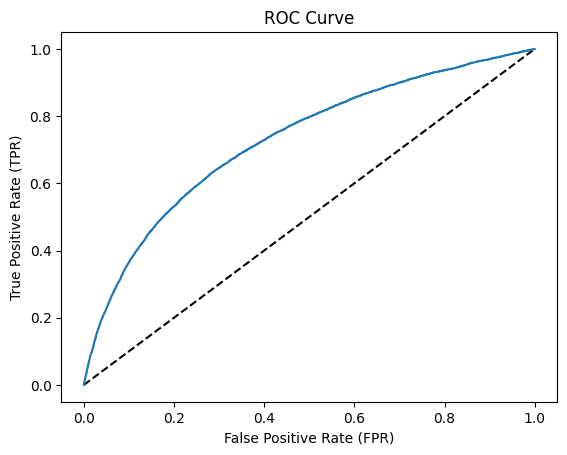

In [27]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

In [28]:
# ROC score
auc_roc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7278842502266173


### Random Forest

In [29]:
RFmodel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed).fit(X_train, y_train)

In [30]:
y_pred = RFmodel.predict(X_test)
accuracy_score(y_test, y_pred)

0.8580387205387205

#### ROC Curve

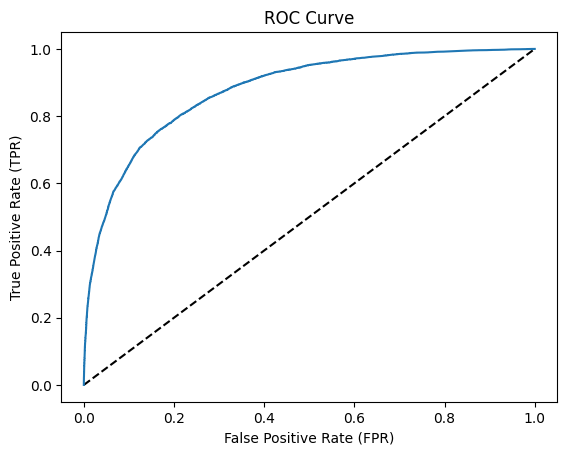

In [31]:
# ROC Curve
y_prob = RFmodel.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

In [32]:
# ROC score
auc_roc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8793432817611206


### XGBoost

In [33]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, random_state=seed).fit(X_train, y_train)

In [34]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.868013468013468

#### ROC Curve

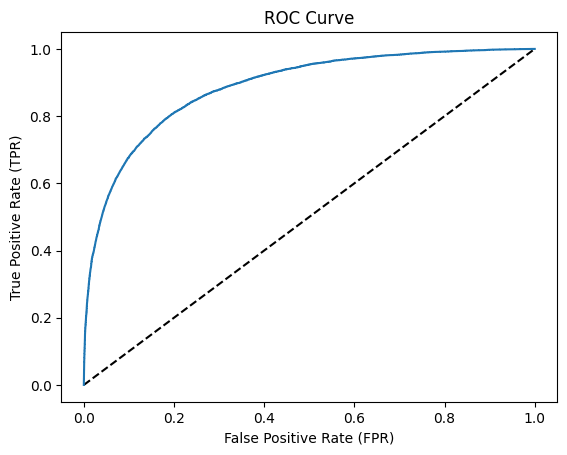

In [36]:
# ROC curve
y_prob = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

In [37]:
auc_roc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8865915902279539


# Submission

In [38]:
# Drop unwanted columns
test = test.drop(['id', 'CustomerId', 'Surname'], axis = 1)
test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,0,0,23.0,2,0.00,2,0,1,160976.75
1,683,0,0,46.0,2,0.00,1,1,0,72549.27
2,656,0,0,34.0,7,0.00,2,1,0,138882.09
3,681,0,1,36.0,8,0.00,1,1,0,113931.57
4,752,1,1,38.0,10,121263.62,1,1,0,139431.00


In [39]:
xgb_preds = xgb.predict(test)

In [40]:
# Render results to a dataframe 
results_df =  pd.DataFrame({"id": test_ids.values, 'Exited': xgb_preds})
results_df.shape

(110023, 2)

In [41]:
# Export to csv
results_df.to_csv('submission.csv', index=False)

Citation:  
@misc{playground-series-s4e1,
    author = {Walter Reade, Ashley Chow},
    title = {Binary Classification with a Bank Churn Dataset },
    publisher = {Kaggle},
    year = {2024},
    url = {https://kaggle.com/competitions/playground-series-s4e1}
}